# Active Users Problem

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Creating a Dataset

In [2]:
import pandas as pd
import uuid
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import skewnorm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
num_users = 10000
np.random.seed(31)

In [4]:
features = [
    "id",
    "gender",
    "age",
    "marital_status",
    "annual_income",
    "education",
    "tos_score"
]

# Creating a DF for these features
df = pd.DataFrame(columns=features)

# ID
df['id'] = [uuid.uuid4().hex for i in range(num_users)]

# GENDER
genders = ["male", "female", "na"]
df['gender'] = random.choices(
    genders, 
    weights=(47,47,6), 
    k=num_users
)

# AGE
df['age'] = np.random.randint(18,65, size=num_users)

# MARITAL STATUS
maritals = ["married", "divorced", "separated", "widowed", "never married"]
df['marital_status'] = random.choices(
    maritals, 
    weights=(40,7,3,5,45), 
    k=num_users
)

# ANNUAL INCOME
df['annual_income'] = skewnorm.rvs(10, loc=72500, scale=30000, size=num_users)

# EDUCATION
eds = ["high-school", "diploma", "degree", "post-grad", "no high-school"]
df['education'] = random.choices(
    eds, 
    weights=(28,22,32,9,9), 
    k=num_users
)

Now I'm going to generate a score for users' time on site/app. While there could be multiple ways to define this score I think the most straight-forward approach would be to assign each user a value based on the number of minutes the user spends on the site/app across the month. 

As this problem involves two general groups of user behaviour (0 to little use of the site/app, and left skewed use of the site/app throughout the rest of the user base), I'm creating two separate distributions and concatenating them together to make a "Time on Site Score".

In [5]:
right = skewnorm.rvs(25, loc=30, size=num_users//2)
right = right - min(right)      #Shift the set so the minimum value is equal to zero.
right = right / max(right)      #Standadize all the vlues between 0 and 1. 
right = right * 30         #Multiply the standardized values by the maximum value.

left = skewnorm.rvs(-5, loc=100, size=num_users//2)
left = left - min(left)      #Shift the set so the minimum value is equal to zero.
left = left / max(left)      #Standadize all the vlues between 0 and 1. 
left = left * 100         #Multiply the standardized values by the maximum value.

tos_score = np.concatenate((left,right))
df['tos_score'] = tos_score

In [6]:
df.head()

,id,gender,age,marital_status,annual_income,education,tos_score
0,eae37201f9244f8c8ab245a44059ad3e,male,36,never married,73751.656243,degree,86.027853
1,836e012578ab49fc89d0f0ae68f7fcd7,female,41,never married,75543.405166,degree,76.682427
2,f8062ee4d14b42ba8a436f23d2262e19,female,34,married,77071.875455,high-school,65.210673
3,10dc0ca0d77a4cfa9a860f6336cda967,male,52,never married,93881.190024,high-school,59.094787
4,72ab19b0b70b40b3b310ddc717c97292,female,41,married,142498.029249,high-school,58.736683


Now we have our dataset!

In [7]:
df.dtypes

id                 object
gender             object
age                 int64
marital_status     object
annual_income     float64
education          object
tos_score         float64
dtype: object

## Visualizing the Data

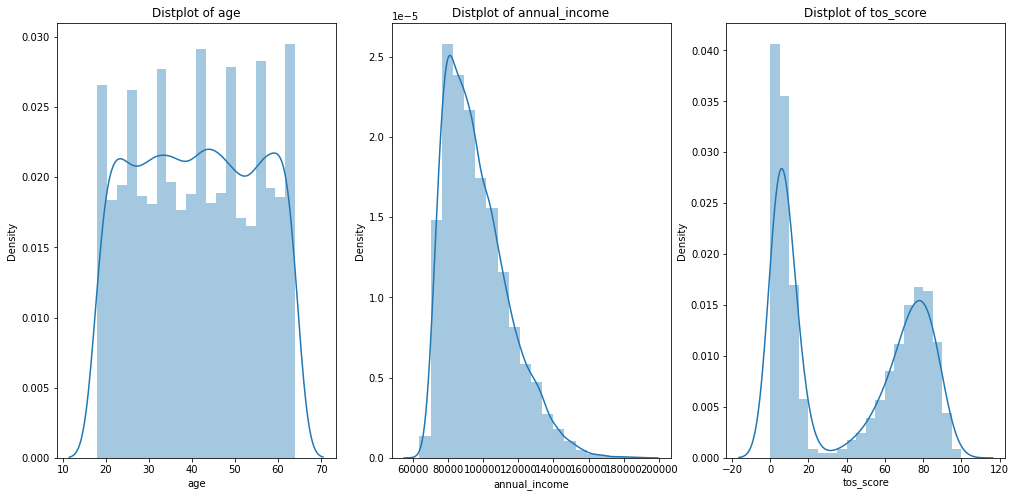

In [8]:
plt.figure(1 , figsize = (17 , 8))
n = 0 
for x in ['age' , 'annual_income' , 'tos_score']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()


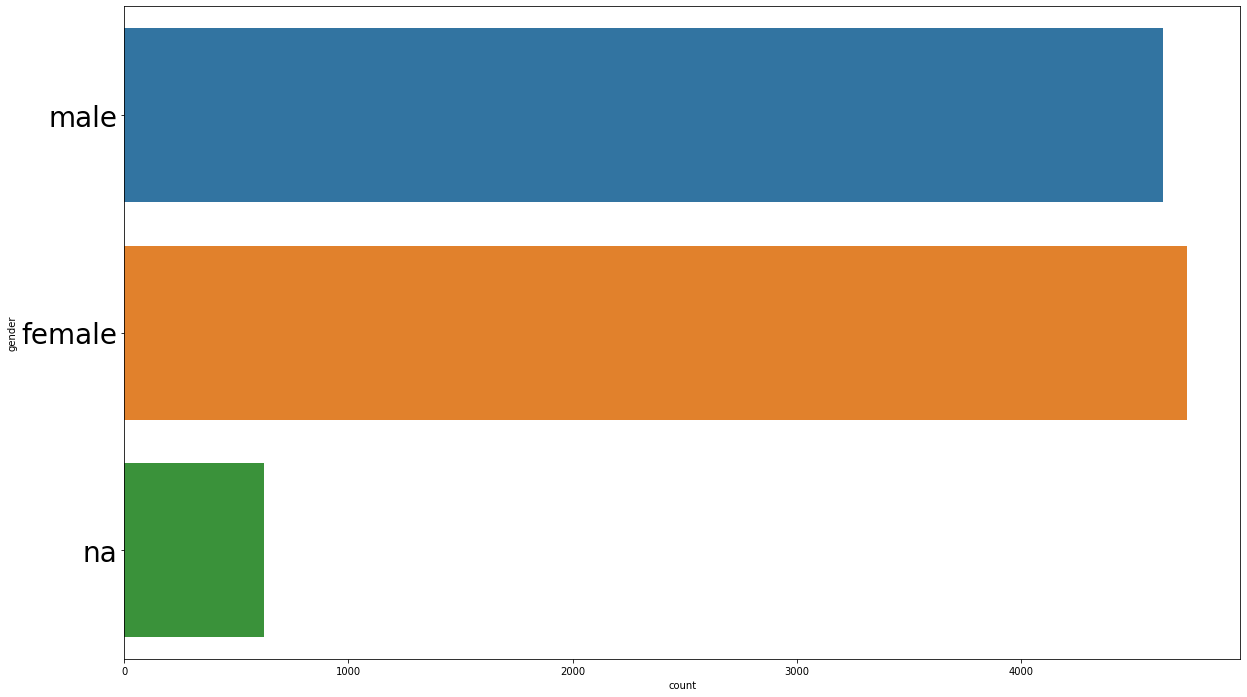

In [9]:
plt.figure(1 , figsize = (20 , 12))
sns.countplot(y = 'gender' , data = df)
plt.yticks(fontsize=28)
plt.show()

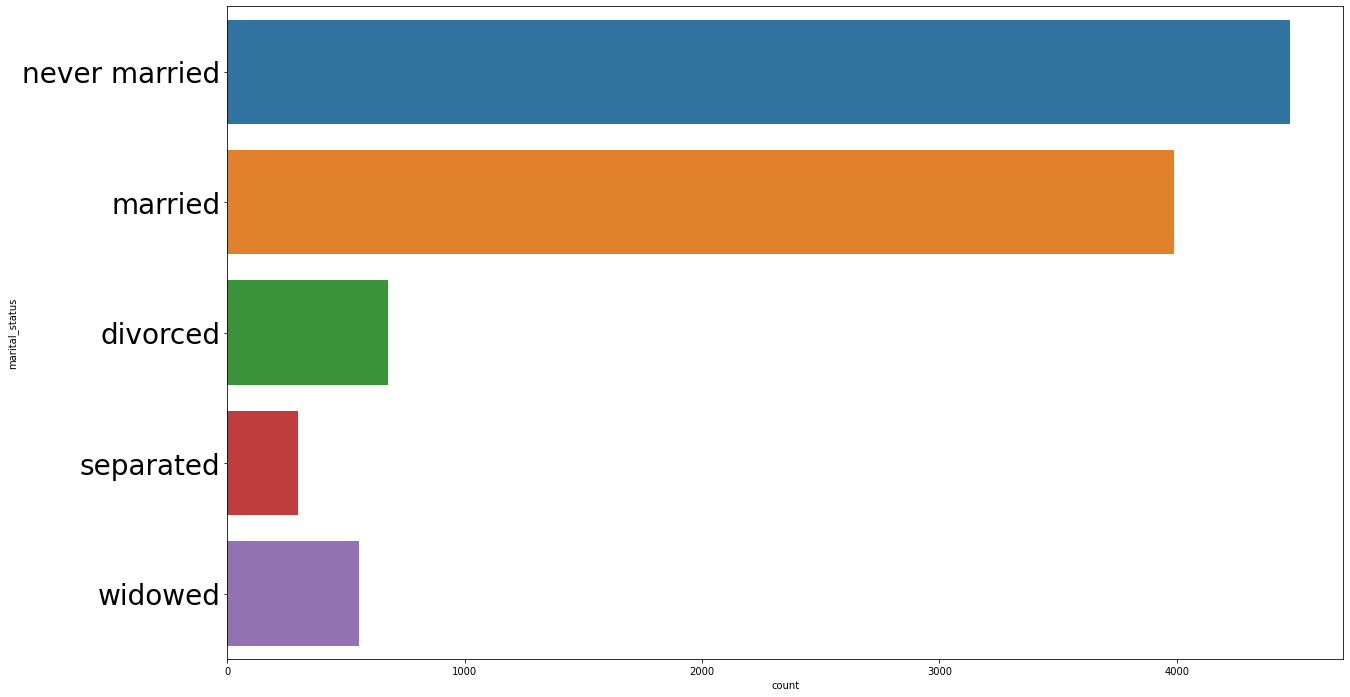

In [10]:
plt.figure(1 , figsize = (20 , 12))
sns.countplot(y = 'marital_status' , data = df)
plt.yticks(fontsize=28)
plt.show()

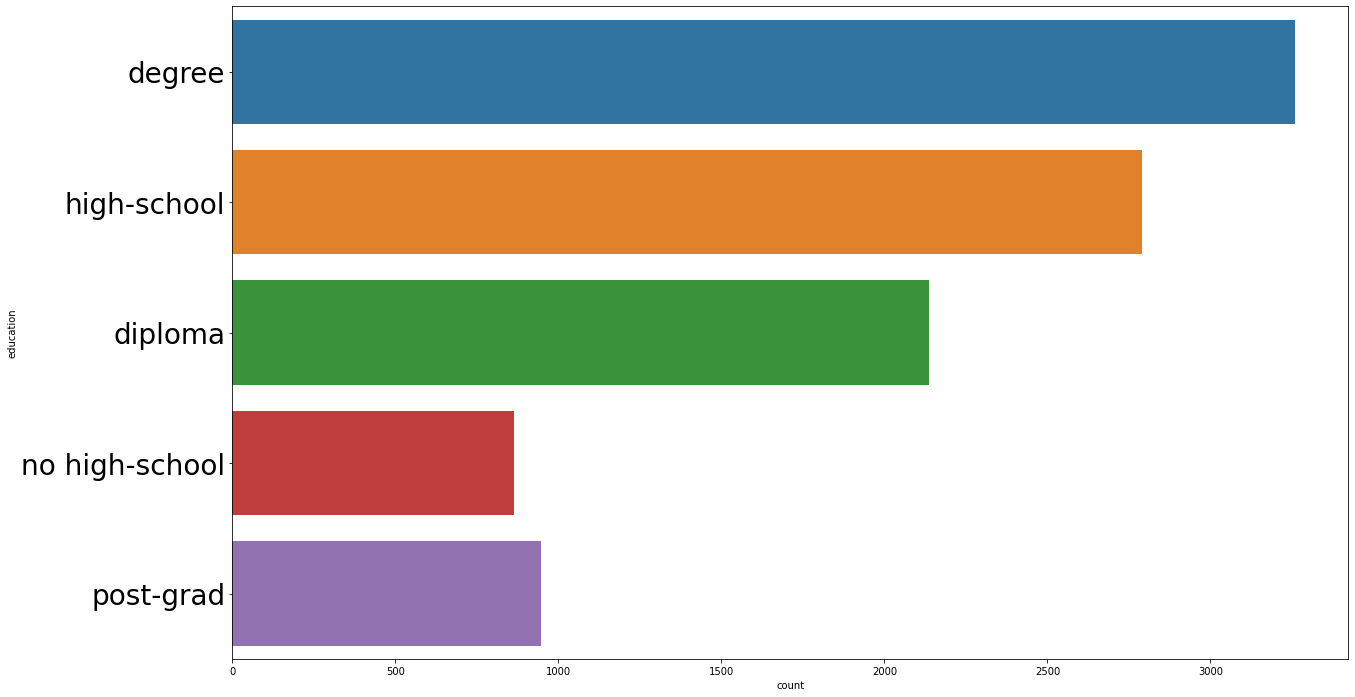

In [11]:
plt.figure(1 , figsize = (20 , 12))
sns.countplot(y = 'education' , data = df)
plt.yticks(fontsize=28)
plt.show()

## K-Means 

First, we'll need to convert our object variables to float

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
# Label encoding gender variable
le = LabelEncoder()
gender_label = le.fit_transform(df['gender'])
df["gender_label"] = gender_label

# Label encoding marital_status variable
ms_label = le.fit_transform(df['marital_status'])
df["ms_label"] = ms_label

# Label encoding education variable
education_label = le.fit_transform(df['education'])
df["education_label"] = education_label

Then I'll separate out users with low TOS scores and users with high TOS scores, as we want to build a working customer profile for both groups.

In [14]:
df_hightos = df.where(df['tos_score'] >= 35)
df_hightos = df_hightos.dropna()
df_hightos.describe()

,age,annual_income,tos_score,gender_label,ms_label,education_label
count,4960.000000,4960.000000,4960.000000,4960.000000,4960.000000,4960.000000
mean,41.204839,96912.101747,73.273384,0.577621,1.606452,1.423387
std,13.582205,18549.692246,12.257015,0.600819,0.876043,1.277955
min,18.000000,63757.699769,35.025832,0.000000,0.000000,0.000000
25%,29.000000,82390.903897,65.863956,0.000000,1.000000,0.000000
50%,41.000000,93251.094089,75.071610,1.000000,2.000000,1.000000
75%,53.000000,107390.758469,82.430334,1.000000,2.000000,2.000000
max,64.000000,190669.333073,100.000000,2.000000,4.000000,4.000000


In [15]:
df_lowtos = df.where(df['tos_score'] < 35)
df_lowtos = df_lowtos.dropna()
df_lowtos.describe()

,age,annual_income,tos_score,gender_label,ms_label,education_label
count,5040.00000,5040.000000,5040.000000,5040.000000,5040.000000,5040.000000
mean,41.05377,96072.198420,7.205412,0.598810,1.606349,1.396627
std,13.57816,17957.762020,5.040062,0.610615,0.876021,1.279088
min,18.00000,64477.743586,0.000000,0.000000,0.000000,0.000000
25%,29.00000,81871.348233,3.384026,0.000000,1.000000,0.000000
50%,41.00000,92601.512896,6.139182,1.000000,2.000000,1.000000
75%,53.00000,106731.460088,9.897614,1.000000,2.000000,2.000000
max,64.00000,183381.612682,34.928351,2.000000,4.000000,4.000000


Then we'll select features for the models

In [16]:
df_hightos.dtypes

id                  object
gender              object
age                float64
marital_status      object
annual_income      float64
education           object
tos_score          float64
gender_label       float64
ms_label           float64
education_label    float64
dtype: object

In [61]:
x = df_hightos.iloc[:, [2,4,6,7,8,9]]
print(x)

       age  annual_income  tos_score  gender_label  ms_label  education_label
0     36.0   73751.656243  86.027853           1.0       2.0              0.0
1     41.0   75543.405166  76.682427           0.0       2.0              0.0
2     34.0   77071.875455  65.210673           0.0       1.0              2.0
3     52.0   93881.190024  59.094787           1.0       2.0              2.0
4     41.0  142498.029249  58.736683           0.0       1.0              2.0
...    ...            ...        ...           ...       ...              ...
4995  37.0   81339.383896  78.719370           0.0       2.0              1.0
4996  48.0   86818.871662  81.622291           1.0       1.0              4.0
4997  47.0   97089.917094  72.280620           0.0       1.0              0.0
4998  43.0   91264.018682  75.431146           0.0       1.0              0.0
4999  33.0  100046.986592  63.065220           0.0       1.0              3.0

[4960 rows x 6 columns]


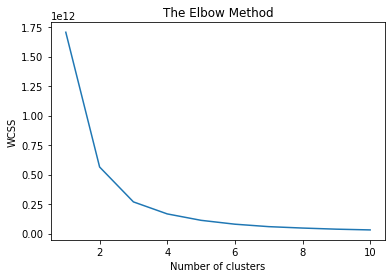

In [43]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 29)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The elbow comes at k = 3 so we will set the model to 3 clusters

In [58]:
from sklearn.cluster import SpectralClustering

ModuleNotFoundError: No module named 'sklearn.datasets.samples_generator'

In [ ]:
sc = SpectralClustering(n_clusters=3).fit(x)
print(sc)

In [44]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 29)
#Let's predict the x
x_kmeans = kmeans.fit_predict(x)

In [45]:
print(x_kmeans)

[2 2 2 ... 0 2 0]


In [46]:
df_hightos['kmeans'] = x_kmeans

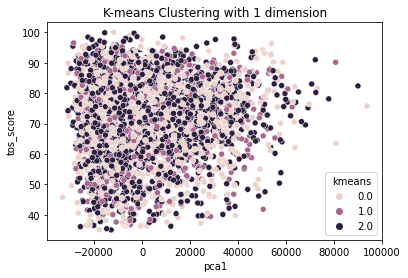

In [56]:
pca_num_components = 1

reduced_data_x = PCA(n_components=pca_num_components).fit_transform(df_hightos.iloc[:, [2,4,6,7,8,9]])
results_x = pd.DataFrame(reduced_data_x,columns=['pca1'])

sns.scatterplot(x="pca1", y=df_hightos['tos_score'], hue=df_hightos['kmeans'], data=results_x)
plt.title('K-means Clustering with 1 dimension')
plt.show()

In [48]:
y = df_lowtos.iloc[:, [2,4,6,7,8,9]].values
print(y)

[[2.50000000e+01 1.09569223e+05 2.54051682e+01 1.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [6.20000000e+01 1.14240868e+05 3.40606223e+01 1.00000000e+00
  2.00000000e+00 1.00000000e+00]
 [1.80000000e+01 1.32497098e+05 3.17607819e+01 0.00000000e+00
  3.00000000e+00 2.00000000e+00]
 ...
 [4.70000000e+01 9.68023863e+04 1.17982663e+01 0.00000000e+00
  2.00000000e+00 4.00000000e+00]
 [4.80000000e+01 8.99384170e+04 7.35006412e+00 0.00000000e+00
  1.00000000e+00 2.00000000e+00]
 [2.70000000e+01 7.64712876e+04 1.40512618e+00 1.00000000e+00
  1.00000000e+00 0.00000000e+00]]


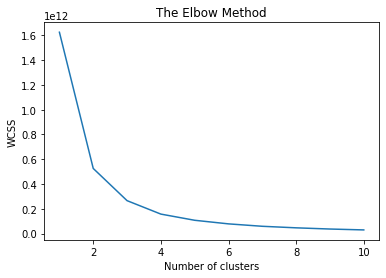

In [49]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 33)
    kmeans.fit(y)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The elbow comes at k = 3 so we will set the model to 3 clusters

In [50]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 33)
#Let's predict the y
y_kmeans = kmeans.fit_predict(y)

In [51]:
print(y_kmeans)

[2 2 1 ... 2 0 0]


In [52]:
df_lowtos['kmeans'] = y_kmeans

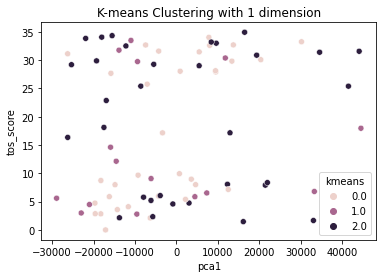

In [57]:
pca_num_components = 1

reduced_data_y = PCA(n_components=pca_num_components).fit_transform(df_lowtos.iloc[:, [2,4,6,7,8,9]])
results_y = pd.DataFrame(reduced_data_y,columns=['pca1'])

sns.scatterplot(x="pca1", y=df_lowtos['tos_score'], hue=df_lowtos['kmeans'], data=results_y)
plt.title('K-means Clustering with 1 dimension')
plt.show()

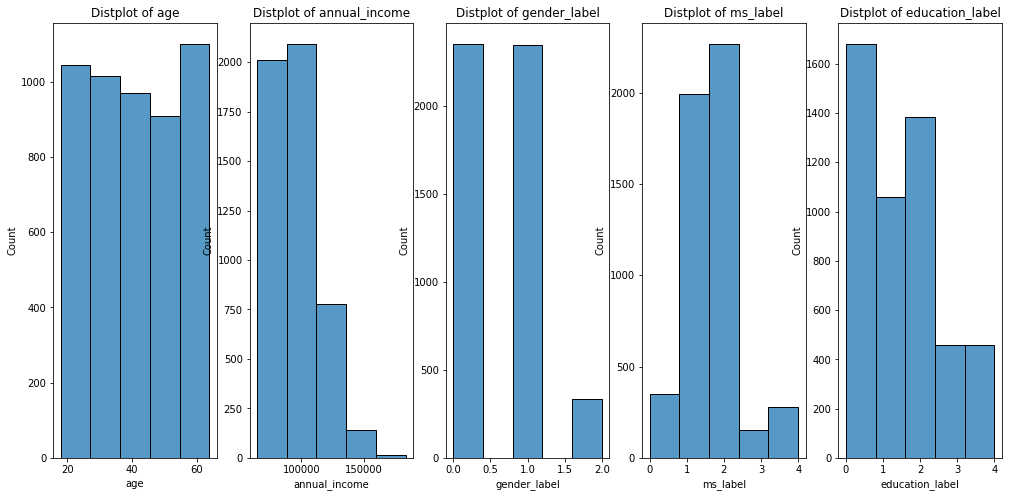

In [54]:
plt.figure(1 , figsize = (17 , 8))
n = 0 
for y in ['age', 'annual_income', 'gender_label', 'ms_label', 'education_label']:
    n += 1
    plt.subplot(1 , 5 , n)
    sns.histplot(df_lowtos[y], bins = 5)
    plt.title('Distplot of {}'.format(y))
plt.show()

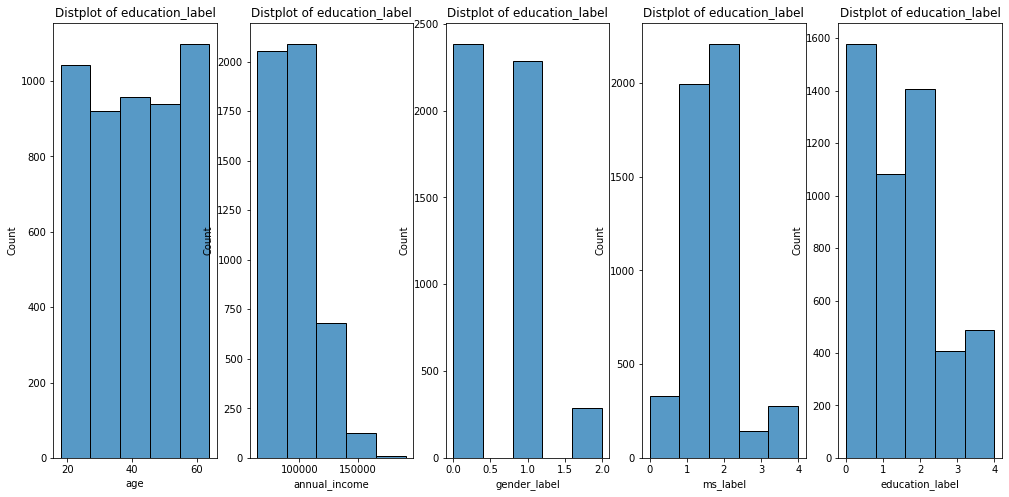

In [55]:
plt.figure(1 , figsize = (17 , 8))
n = 0 
for x in ['age', 'annual_income', 'gender_label', 'ms_label', 'education_label']:
    n += 1
    plt.subplot(1 , 5 , n)
    sns.histplot(df_hightos[x], bins = 5)
    plt.title('Distplot of {}'.format(y))
plt.show()

As you can see there isn't much difference demo-wise between high-TOS customers and low-TOS customers.

Would this be different with actual data compared to a randomized dataset?